In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import qutip
import theano
import theano.tensor as T
import QubitNetwork
from QubitNetwork import QubitNetwork, load_network_from_file
from collections import OrderedDict
import utils
from utils import chop, complex2bigreal, bigreal2complex, transfer_J_values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions='all',
    self_interactions=('all', ['z']),
    system_qubits=[0, 1, 2]
#     J=new_Jvalues
)
net, _ = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=200,
    batch_size=10,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01,
    saveafter_file='nets/test.pickle'
)

AttributeError: module 'qutip' has no attribute 'toffolib'

Let us see how the constructed gate actually implements the toffoli.
More specifically, the optimization only assures that we are getting a gate of the form
$$ \mathcal U = \tilde{\mathcal U} \otimes P_A + (...)$$
where $P_A$ is the projector over the ancilla state that was used for the training.
This means that in the case under consideration we should have
$$ \mathcal U = \mathcal U_{toffoli} \otimes \begin{pmatrix}1&0\\0&0\end{pmatrix} + (...).$$
As shown below, this seems to be indeed the case:

In [93]:
net = QubitNetwork.load_network_from_file('nets/toffoli.pickle')
gate = qutip.Qobj(net.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)

p00 = qutip.ket2dm(qutip.basis(2, 0))
p11 = qutip.ket2dm(qutip.basis(2, 1))
p01 = qutip.Qobj([[0, 1], [0, 0]])
p10 = qutip.Qobj([[0, 0], [1, 0]])

i3 = qutip.tensor([qutip.qeye(2) for _ in range(3)])
ntlp = utils.normalize_topleft_phase

extracted1 = (qutip.tensor(i3, p00) * gate * qutip.tensor(i3, p00)).ptrace([0, 1, 2])
extracted2 = (qutip.tensor(i3, p11) * gate * qutip.tensor(i3, p11)).ptrace([0, 1, 2])
extracted3 = (qutip.tensor(i3, p01) * gate * qutip.tensor(i3, p01)).ptrace([0, 1, 2])
extracted4 = (qutip.tensor(i3, p10) * gate * qutip.tensor(i3, p10)).ptrace([0, 1, 2])

display(chop(ntlp(chop(extracted1))))
display(ntlp(chop(extracted2)))
display(ntlp(chop(extracted3)))
display(ntlp(chop(extracted4)))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[  5.83951148e-01+0.j           1.62434082e-01-0.58318838j
   -3.07493013e-01-0.14184159j  -1.09834616e-01+0.38909997j
    6.55944180e-02-0.04760238j   4.27745341e-03+0.01784894j
    5.83608871e-02+0.04454531j   1.93010523e-02-0.04130145j]
 [  1.62437461e-01-0.58319103j   5.31745528e-01+0.27921003j
   -2.16308406e-01+0.34791808j  -2.72841947e-01-0.15085488j
   -1.41142187e-02-0.01473078j  -1.83223806e-02+0.01353968j
   -5.68142758e-02-0.04111847j   7.74963606e-03+0.04290244j]
 [ -4.62114482e-02+0.18397513j   4.58262614e-01+0.16343632j
   -1.08457710e-01+0.1673485j    7.46808372e-01+0.280339j
   -1.00059273e-01-0.1047949j   -4.23474798e-04+0.00411472j
    1.27962085e-01+0.10846802j  -3.67550730e-02-0.02681088j]
 [  4.78207181e-01+0.10814268j  -6.63162531e-02+0.14325996j
    6.68834189e-01+0.41803916j  -1.84049724e-02+0.22339884j
    6.42882289e-03+0.05188583j   3.40797257e-03+0.059132

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

In [94]:
net.save_gate_to_file('matrices/toffoli_4q1a_all_all.csv')

In [44]:
Jvalues = net.J.get_value()
display(Jvalues)
# [net.J_index_to_interaction(v) for v in np.where(np.abs(Jvalues) < 1e-3)[0]]
# net.active_hs

array([  1.87000602e+00,   2.16314398e+00,  -6.34280758e-01,
        -1.43185669e+00,  -2.26583486e-01,   1.48457146e-01,
        -5.51012222e-02,  -1.48582117e-01,  -2.26554949e-01,
        -9.29009023e-02,  -2.29440692e+00,   3.93267029e-01,
         1.20565591e+00,  -9.20444695e-02,  -1.70732662e-01,
         3.28081756e-01,   6.44053652e-02,  -3.28134102e-01,
        -1.70706718e-01,   1.72991276e+00,  -2.86816694e-01,
         1.85684167e+00,   8.52963605e-06,   4.84895298e-07,
        -1.47158031e-01,  -4.74586988e-07,   8.57338836e-06,
        -2.84515193e-02,   3.79143042e-07,   2.59604261e-07,
         8.89976429e-01,   2.22197952e+00,   9.64549375e-01,
        -4.71647831e-01,  -1.85413750e+00,   4.71650147e-01,
         9.64541125e-01,  -3.86453088e+00,  -2.03959615e-01,
        -7.87375400e-01,   6.29098329e-07,  -7.93233727e-07,
        -7.24257751e-02,  -4.52798637e-07,  -6.93876287e-08,
        -1.46086927e+00,   1.12940873e-06,   6.74970597e-08,
        -8.14000200e-01,

Vanishing interactions:

In [54]:
vanishing_indices = np.where(np.abs(Jvalues) < 1e-5)[0]
[net.J_index_to_interaction(v) for v in vanishing_indices]

[((0, 3), 'xx'),
 ((0, 3), 'xy'),
 ((0, 3), 'yx'),
 ((0, 3), 'yy'),
 ((0, 3), 'zx'),
 ((0, 3), 'zy'),
 ((1, 3), 'xx'),
 ((1, 3), 'xy'),
 ((1, 3), 'yx'),
 ((1, 3), 'yy'),
 ((1, 3), 'zx'),
 ((1, 3), 'zy'),
 ((2, 3), 'xx'),
 ((2, 3), 'xy'),
 ((2, 3), 'yx'),
 ((2, 3), 'yy'),
 ((2, 3), 'zx'),
 ((2, 3), 'zy')]

In [46]:
groups = utils.group_similar_elements(Jvalues)
groups = [g for g in groups if len(g) > 1]


[[net.J_index_to_interaction(i) for i in groups[j]] for j in range(len(groups))]

[[((0, 1), 'xx'), ((0, 1), 'yy')],
 [((0, 1), 'yz'), ((0, 2), 'xx')],
 [((0, 2), 'xy'), ((0, 2), 'yz')],
 [((0, 3), 'xx'),
  ((0, 3), 'xy'),
  ((0, 3), 'yx'),
  ((0, 3), 'yy'),
  ((0, 3), 'zx'),
  ((0, 3), 'zy'),
  ((1, 3), 'xx'),
  ((1, 3), 'xy'),
  ((1, 3), 'yx'),
  ((1, 3), 'yy'),
  ((1, 3), 'zx'),
  ((1, 3), 'zy'),
  ((2, 3), 'xx'),
  ((2, 3), 'xy'),
  ((2, 3), 'yx'),
  ((2, 3), 'yy'),
  ((2, 3), 'zx'),
  ((2, 3), 'zy')],
 [((1, 2), 'xy'), ((1, 2), 'yz')]]

OrderedDict([((0, 1), ['zz']), ((0, 2), ['zz']), ((1, 2), ['zz']), ((0, 3), ['xx']), ((1, 3), ['zz']), ((2, 3), ['zz'])])
Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


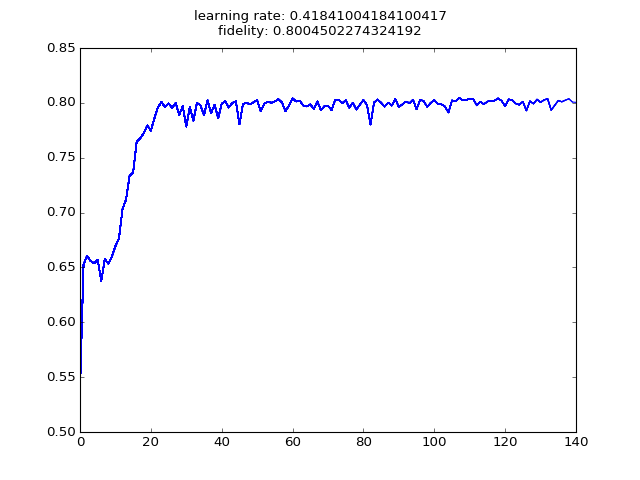

Finished training


In [67]:
interactions = OrderedDict([((0, 1), 'zz'),
                            ((0, 2), 'zz'),
                            ((1, 2), 'zz'),
                            ((0, 3), 'xx'),
                            ((1, 3), 'zz'),
                            ((2, 3), 'zz')])
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions=interactions,
    self_interactions=('all', ['x', 'z']),
    system_qubits=3
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
#     saveafter_file='nets/fredkin_best.pickle'
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


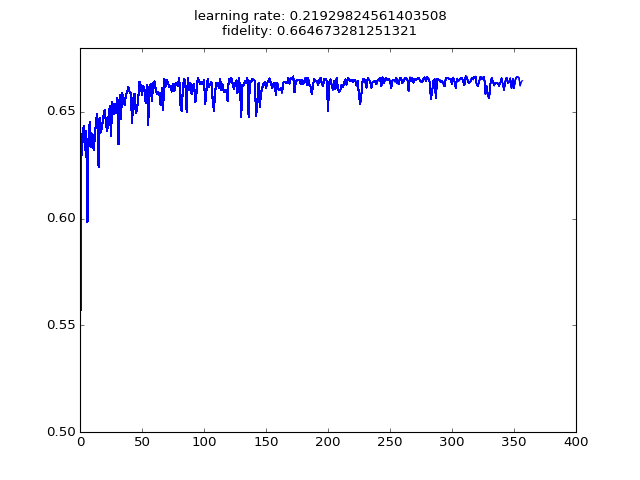

Finished training


In [74]:
interactions = OrderedDict([((0, 1), 'zz'),
                            ((0, 2), 'zz'),
                            ((1, 2), 'zz'),
                            ((0, 3), 'xx'),
                            ((1, 3), 'zz'),
                            ((2, 3), 'zz')])
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    self_interactions=('all', ['x', 'z']),
    ancillae_state=qutip.Qobj([[1], [1]]).unit()
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


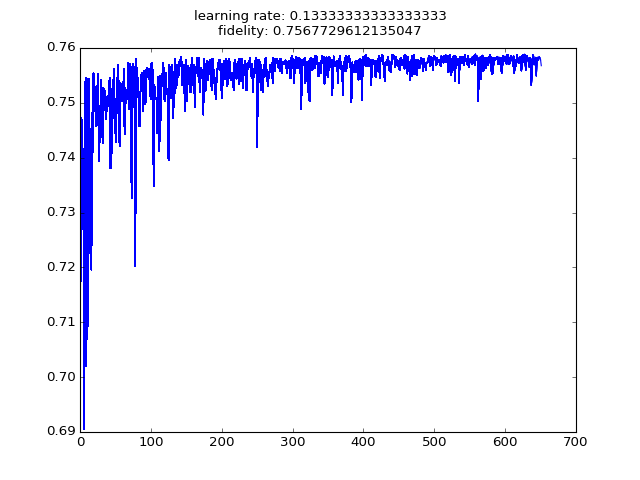

Finished training


In [78]:
interactions = OrderedDict([((0, 1), 'zz'),
                            ((0, 2), 'zz'),
                            ((1, 2), 'zz'),
                            ((0, 3), 'xx'),
                            ((1, 3), 'zz'),
                            ((2, 3), 'zz')])
eta = 0.8182
xi = 0.0587
initial_ancilla = qutip.Qobj([[np.cos(eta)], [np.sin(eta)]])
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    self_interactions=('all', ['x', 'z']),
    ancillae_state=initial_ancilla
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


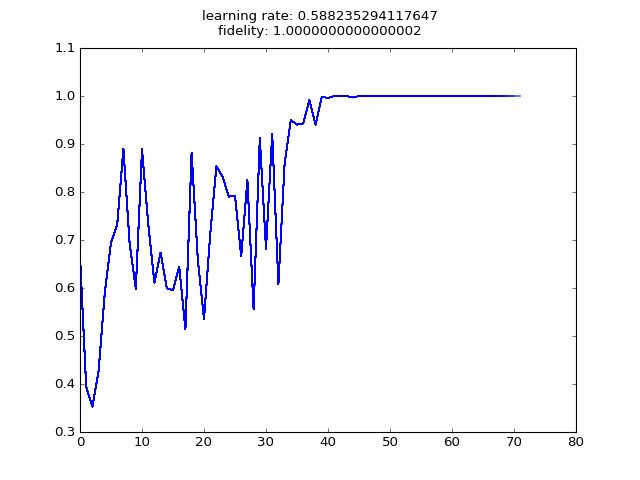

Finished training


In [83]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['xx', 'yy', 'zz', 'xy', 'xz']),
    self_interactions=('all', ['z']),
    ancillae_state=qutip.basis(2, 0)
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


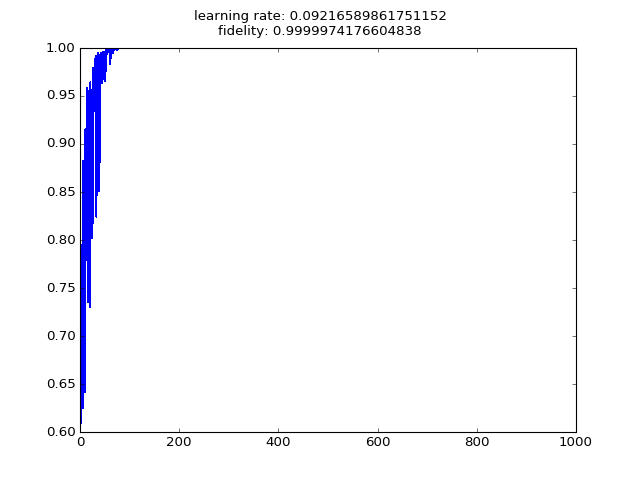

Finished training


In [95]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['xx', 'yy', 'zz', 'xy', 'xz']),
    self_interactions=('all', ['z']),
    ancillae_state=qutip.basis(2, 0)
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

In [86]:
gate = qutip.Qobj(net.get_current_gate())
v = net.J.get_value()
display(v)
[net.J_index_to_interaction(i) for i in np.where(np.abs(v) < 1e-4)[0]]

array([ -6.52402143e-01,  -2.07332394e+00,  -9.10442496e-01,
        -3.57376459e+00,  -5.86128105e-01,  -5.86128106e-01,
        -1.97998775e-01,  -1.19626243e-10,   2.22029562e+00,
        -3.03004891e+00,  -2.00570054e-01,  -1.50114777e+00,
        -9.89953368e-12,   2.00570061e-01,   7.15164615e-17,
        -7.42495899e-17,   2.52311098e+00,   1.18863393e-16,
        -8.09753288e-01,  -1.21204325e+00,   2.06895794e-01,
        -5.41506187e-01,  -8.09827237e-10,  -2.06895791e-01,
        -1.51093770e-16,   1.64317900e-16,  -7.26981481e-01,
         4.32337040e-17,  -1.21204325e+00,  -2.07369048e-16,
        -1.82325480e-17,  -1.13221147e+00,   1.71342562e-16,
        -4.46499430e-01])

[((0, 1), 'xy'),
 ((0, 2), 'xy'),
 ((0, 3), 'xx'),
 ((0, 3), 'yy'),
 ((0, 3), 'xy'),
 ((1, 2), 'xy'),
 ((1, 3), 'xx'),
 ((1, 3), 'yy'),
 ((1, 3), 'xy'),
 ((2, 3), 'xx'),
 ((2, 3), 'yy'),
 ((2, 3), 'xy')]

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


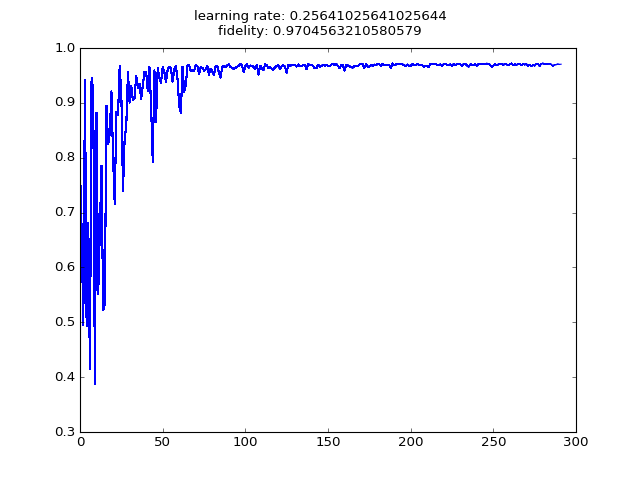

Finished training


In [91]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['xx', 'yy', 'zz', 'xz']),
    self_interactions=('all', ['z']),
    ancillae_state=qutip.basis(2, 0)
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

In [92]:
gate = qutip.Qobj(net.get_current_gate())
v = net.J.get_value()
display(v)
[net.J_index_to_interaction(i) for i in np.where(np.abs(v) < 1e-4)[0]]

array([  8.10421190e-01,  -9.11249150e-01,  -7.97174292e-01,
        -1.54023562e+00,   9.60764940e-01,   7.39277268e-02,
         9.59623229e-01,  -3.96814011e-01,   1.55057448e+00,
        -4.32879781e-02,  -4.70793152e-02,  -7.98350821e-01,
        -1.12558778e-16,  -2.97284510e-17,  -1.51598088e+00,
         1.50451094e+00,   5.27069558e-01,  -1.30484883e+00,
        -8.01485583e-01,   1.51572685e+00,  -2.35169840e-16,
         1.37765145e-16,  -1.66028782e+00,   8.90863881e-02,
        -2.57330034e-17,  -1.00241583e-16,   4.31923000e-01,
         1.72433653e-01])

[((0, 3), 'xx'),
 ((0, 3), 'yy'),
 ((1, 3), 'xx'),
 ((1, 3), 'yy'),
 ((2, 3), 'xx'),
 ((2, 3), 'yy')]

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


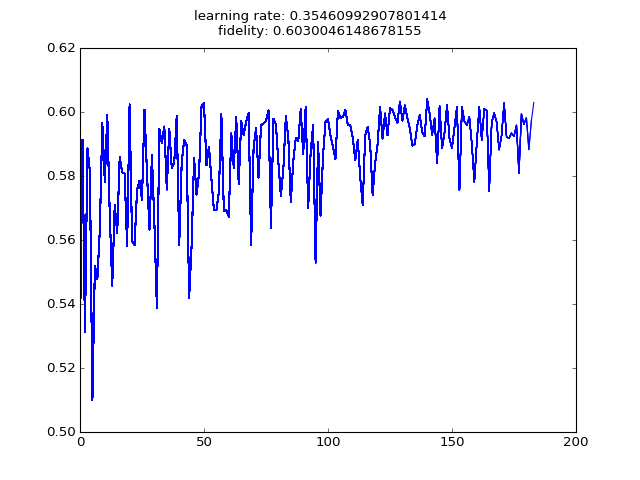

Finished training


In [90]:
interactions = OrderedDict([((0, 1), 'zz'), ((0, 2), 'zz'), ((0, 3), 'zz'),
                            ((1, 2), 'zz'), ((1, 3), 'zz'), ((2, 3), 'zz'),
                            ((0, 1), 'xz'), ((0, 2), 'xz'), ((0, 3), 'xz'),
                            ((1, 2), 'xz'), ((1, 3), 'xz'), ((2, 3), 'xz'),
                            ((0, 1), 'xx'), ((0, 2), 'xx'), ((1, 2), 'zz'),
                            ((0, 1), 'yy'), ((0, 2), 'yy'), ((1, 2), 'yy')])
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    self_interactions=('all', ['z']),
    ancillae_state=qutip.basis(2, 0)
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

In [6]:
net1 = load_network_from_file('nets/toffoli.pickle')
net2 = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    self_interactions=('all', ['z']),
    ancillae_state=qutip.basis(2, 0)
)

net1.active_hs()

AttributeError: type object 'QubitNetwork' has no attribute 'QubitNetwork'